<a href="https://colab.research.google.com/github/Wickstrom/InformationTheoryExperiment/blob/master/cnnMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Load data and
import sys
import torch as th
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/content/drive/My Drive/Colab Notebooks/Information/')

from google.colab import drive
drive.mount('/content/drive')

from load_mnist import load_mnist
from IPython.display import clear_output


gpu = th.cuda.is_available()
x_tr, y_tr, x_te, y_te = load_mnist('/content/drive/My Drive/Colab Notebooks/Information/', gpu)

Mounted at /content/drive


In [4]:
#@title define model
import random
import torch.nn as nn
import torch.nn.init as init


class CNN_HERO(nn.Module):
    def __init__(self, a_type, n_iterations):
        super(CNN_HERO, self).__init__()

        self.a_type = a_type

        if a_type == 'relu':
            self.activation = nn.ReLU()
        elif a_type == 'tanh':
            self.activation = nn.Tanh()
        elif a_type == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif a_type == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        else:
            print('Not implemented')
            raise

        self.layer1 = nn.Sequential(
                    *([nn.Conv2d(1, 4, 3),
                       self.activation,
                       nn.BatchNorm2d(4)]))

        self.layer2 = nn.Sequential(
                    *([nn.Conv2d(4, 8, 3),
                       self.activation,
                       nn.BatchNorm2d(8)]))

        self.layer3 = nn.Sequential(
                    *([nn.Conv2d(8, 16, 3),
                       self.activation,
                       nn.BatchNorm2d(16)]))

        self.layer4 = nn.Sequential(
                    *([nn.Linear(5*5*16, 256),
                       self.activation,
                       nn.BatchNorm1d(256)]))

        self.layer5 = nn.Sequential(
                *([nn.Linear(256, 10)]))

        for m in self.modules():
            self.weight_init(m)

        self.pool_layer = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)

        self.sigmas = th.zeros((7, n_iterations)).cuda()
        self.cost =  []
        self.score = []
        self.MI = th.zeros((n_iterations, 5, 2)).cuda()

    def forward(self, x):

        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer2_p = self.pool_layer(layer2)
        layer3 = self.layer3(layer2_p)
        layer3_p = self.pool_layer(layer3)

        N, C, H, W = layer3_p.size()

        layer4 = self.layer4(layer3_p.view(N, -1))
        layer5 = self.layer5(layer4)

        return [layer5, layer4, layer3, layer2, layer1]


    def train_model(self, x, y, model, gpu, optimizer=th.optim.SGD):

        optimizer = optimizer(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        model.train()

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output[0], y)
        loss.backward()
        optimizer.step()

        self.cost.append(loss.item())

        return

    def predict(self, x, y, model, gpu):

        model.eval()
        scores = []

        output = model(x)
        y_hat = th.argmax(self.softmax(output[0]), 1)
        score = th.eq(y, y_hat).sum().float() / x.size(0)
        self.score.append(score.item())

        return

    def dist_mat(self, x):

        try:
            x = th.from_numpy(x)
        except TypeError:
            x = x

        if len(x.size()) == 4:
            x = x.view(x.size()[0], -1)

        dist = th.norm(x[:, None] - x, dim=2)
        return dist

    def entropy(self, *args):

        for idx, val in enumerate(args):
            if idx == 0:
                k = val.clone()
            else:
                k *= val

        k /= k.trace()

        eigv = th.linalg.eigh(k)[0].abs()

        return -(eigv*(eigv.log2())).sum()


    def kernel_mat(self, x, k_x, k_y, sigma=None, epoch=None, idx=None):

        d = self.dist_mat(x)
        if sigma is None:
          if epoch > 40:
            sigma_vals = th.linspace(0.1, 10*d.mean().item(), 50).cuda()
          else:
            sigma_vals = th.linspace(0.1, 10*d.mean().item(), 75).cuda()
          L = []
          for sig in sigma_vals:
            k_l = th.exp(-d ** 2 / (sig ** 2)) / d.size(0)
            L.append(self.kernel_loss(k_x, k_y, k_l, idx))

          if epoch == 0:
            self.sigmas[idx+1, epoch] = sigma_vals[L.index(max(L))]
          else:
            self.sigmas[idx+1, epoch] = 0.9*self.sigmas[idx+1, epoch-1] + 0.1*sigma_vals[L.index(max(L))]

          sigma = self.sigmas[idx+1, epoch]

        return th.exp(-d ** 2 / (sigma ** 2))


    def kernel_loss(self, k_x, k_y, k_l, idx):

        b = 1.0
        beta = [b, b, b, b, b]

        L = th.norm(k_l)
        Y = th.norm(k_y) ** beta[idx]
        X = th.norm(k_x) ** (1-beta[idx])

        LY = th.trace(th.matmul(k_l, k_y))**beta[idx]
        LX = th.trace(th.matmul(k_l, k_x))**(1-beta[idx])

        return 2*th.log2((LY*LX)/(L*Y*X))


    def one_hot(self, y, gpu):

        try:
            y = th.from_numpy(y)
        except TypeError:
            None

        y_1d = y
        if gpu:
            y_hot = th.zeros((y.size(0), th.max(y).int()+1)).cuda()
        else:
            y_hot = th.zeros((y.size(0), th.max(y).int()+1))

        for i in range(y.size(0)):
            y_hot[i, y_1d[i].int()] = 1

        return y_hot

    def compute_mi(self, x, y, model, gpu, current_iteration):

        model.eval()

        data = self.forward(x)
        data.reverse()
        data[-1] = self.softmax(data[-1])
        data.insert(0, x)
        data.append(self.one_hot(y, gpu))

        k_x = self.kernel_mat(data[0], [], [], sigma=th.tensor(8.0).cuda())
        k_y = self.kernel_mat(data[-1], [], [], sigma=th.tensor(0.1).cuda())

        k_list = [k_x]
        for idx_l, val in enumerate(data[1:-1]):
          k_list.append(self.kernel_mat(val.reshape(data[0].size(0), -1), k_x, k_y, epoch=current_iteration, idx=idx_l))
        k_list.append(k_y)

        e_list = [self.entropy(i) for i in k_list]
        j_XT = [self.entropy(k_list[0], k_i) for k_i in k_list[1:-1]]
        j_TY = [self.entropy(k_i, k_list[-1]) for k_i in k_list[1:-1]]

        for idx_mi, val_mi in enumerate(e_list[1:-1]):
            self.MI[current_iteration, idx_mi, 0] = e_list[0]+val_mi-j_XT[idx_mi]
            self.MI[current_iteration, idx_mi, 1] = e_list[-1]+val_mi-j_TY[idx_mi]

        return

    def weight_init(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            if self.a_type == 'relu':
                init.kaiming_normal_(m.weight.data, nonlinearity=self.a_type)
                init.constant_(m.bias.data, 0)
            elif self.a_type == 'leaky_relu':
                init.kaiming_normal_(m.weight.data, nonlinearity=self.a_type)
                init.constant_(m.bias.data, 0)
            elif self.a_type == 'tanh':
                g = init.calculate_gain(self.a_type)
                init.xavier_uniform_(m.weight.data, gain=g)
                init.constant_(m.bias.data, 0)
            elif self.a_type == 'sigmoid':
                g = init.calculate_gain(self.a_type)
                init.xavier_uniform_(m.weight.data, gain=g)
                init.constant_(m.bias.data, 0)
            else:
                raise
                return NotImplemented

    def make_batches(self, N, batch_size):

        idx = random.sample(range(0, N), N)

        for i in range(0, N, batch_size):
            yield idx[i:i+batch_size]

Run Number: 0 
 Epoch number: 45 
 Cost: 0.701283872127533 
 Acc: 0.8100000023841858
Run Number: 0 
 Epoch number: 46 
 Cost: 0.7014040946960449 
 Acc: 0.7799999713897705
Run Number: 0 
 Epoch number: 47 
 Cost: 0.6736074090003967 
 Acc: 0.8299999833106995
Run Number: 0 
 Epoch number: 48 
 Cost: 0.6058043837547302 
 Acc: 0.85999995470047
Run Number: 0 
 Epoch number: 49 
 Cost: 0.4937148690223694 
 Acc: 0.8799999952316284


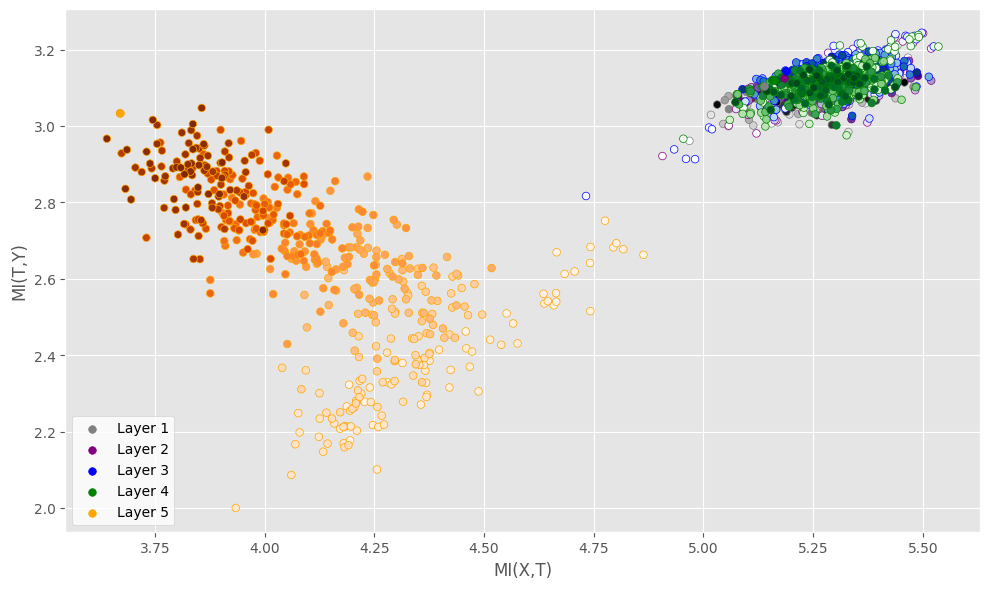

In [5]:
N = 1
batch_size_tr = 100
batch_size_te = 200
epochs = 50
tr_size = 1000
n_iterations = (tr_size // batch_size_tr)*epochs
current_iteration = 0
activation = 'relu'


for n in range(N):

    if gpu:
        model = CNN_HERO(activation, n_iterations).cuda()
    else:
        model = CNN_HERO(activation, n_iterations)

    for epoch in range(epochs):

        batches_tr = list(model.make_batches(tr_size, batch_size_tr))

        for idx_tr in batches_tr:

            x_tr_b = x_tr[idx_tr]
            y_tr_b = y_tr[idx_tr]

            idx_te = random.sample(range(0, 10000), batch_size_te)

            x_te_b = x_tr_b #x_te[idx_te]
            y_te_b = y_tr_b #y_te[idx_te]

            model.train_model(x_tr_b, y_tr_b, model, gpu)
            with th.no_grad():
              model.predict(x_te_b, y_te_b, model, gpu)
              model.compute_mi(x_te_b, y_te_b, model, gpu, current_iteration)
              current_iteration += 1

        if epoch % 5 == 0:
          clear_output()

        print('Run Number: {}'.format(n), '\n',
              'Epoch number: {}'.format(epoch), '\n',
              'Cost: {}'.format(model.cost[-1]), '\n',
              'Acc: {}'.format(model.score[-1]))

xy1 = model.MI.cpu().detach().numpy().reshape(1, n_iterations, 5, 2)

plt.figure(1, figsize=(10, 6))
plt.style.use('ggplot')
c_lab = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
layer = [1, 2, 3, 4, 5, 6]

for m in range(N):
    for j in range(5):
                plt.scatter(xy1[m, :, j, 0], xy1[m, :, j, 1], cmap=c_lab[j], c=np.arange(0, xy1.shape[1], 1), edgecolor=c_lab[j][:-1], s=30)

for j in range(5):
            plt.scatter(xy1[0, -1, j, 0], xy1[0, -1, j, 1], c=c_lab[j][:-1], label='Layer {}'.format(j+1), s=30)

plt.legend(facecolor='white')
plt.xlabel('MI(X,T)')
plt.ylabel('MI(T,Y)')
plt.tight_layout()
plt.show()

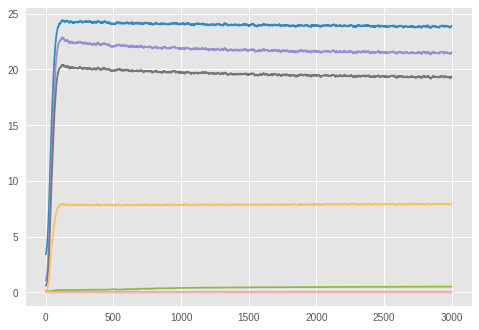

In [ ]:
#np.isnan(model.MI.cpu().detach().numpy()).sum()
plt.plot(model.sigmas.cpu().detach().numpy().T)
#np.isnan(model.sigmas.cpu().detach().numpy()).sum()
np.savez_compressed('sigma_relu_cnn_train.npz', a=model.sigmas.cpu().detach().numpy().T)